# Verification of PMCTRACK cyclones against the STARS dataset

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import string

from arke.cart import lcc_map

from common_defs import (
    aliases,
    bbox,
    conf_key_typeset,
    datasets,
    dset_ctrl_tstep_h,
    nyr,
    winters,
    winter_dates,
    _runs_grid_formatter,
)
from plot_utils import cc, use_style
from match_to_stars import match_options, _make_match_label
from obs_tracks_api import prepare_tracks, read_all_accacia, read_all_stars
import mypaths

In [2]:
tfreq_hours = {"era5": [2, 3, 4, 6, 9, 12], "interim": [6, 9, 12]}

In [3]:
for dataset in datasets:
    print(dataset)
    for x in tfreq_hours[dataset]:
        print(x / dset_ctrl_tstep_h[dataset])

era5
2.0
3.0
4.0
6.0
9.0
12.0
interim
2.0
3.0
4.0


In [4]:
use_style()

### Load preprocessed data

In [5]:
stars_tracks = prepare_tracks(read_all_stars(), bbox)
n_ref = len(stars_tracks)
n_ref

100

Next, we load the output of `match_to_stars.py`, namely text files with IDs of tracked cyclone and corresponding IDs of STARS cyclones that match to each other.

Exactly 100 STARS tracks are used, so the numbers in the plot below are equivalent to %.

In [6]:
run_groups = {
    "vort_thresh": {"group_id": 0, "parameter": "zeta_max0", "control_value": 2e-4, "label": r"Vorticity threshold [$\times10^{-4}$ $s^{-1}}$]"},
    "tfreq": {"group_id": 100, "parameter": "tfreq", "control_value": 1, "label": r"Time step [h]"},
}

In [7]:
def _get_runs_grid(dataset, run_group):
    """Read list of sensitivity run parameters from JSON file."""
    with (mypaths.procdir / f"runs_grid_{run_group}_{dataset}.json").open("r") as fp:
        return json.load(fp)

In [8]:
match_results = {}
for dset in datasets:
    match_results[dset] = {}
    for run_group, run_group_dict in run_groups.items():
        runs_grid = _get_runs_grid(dset, run_group)
        match_counts = np.zeros((len(match_options), len(runs_grid)))
        for match_i, match_option in enumerate(match_options):
            for run_id, run_dict in enumerate(runs_grid, run_group_dict["group_id"]):
                df = pd.read_csv(
                    mypaths.procdir
                    / "matches"
                    / f"{dset}_run{run_id:03d}_2000_2018_{_make_match_label(match_option)}.txt",
                    skiprows=4,
                    names=["pmc", "stars"],
                )
                match_counts[match_i, run_id - run_group_dict["group_id"]] = df.shape[0]
        match_results[dset][run_group] = match_counts

## Vorticity thresholds

In [9]:
def _add_style_and_labels(ax, n_ref, xindices=None, xticklabels=None, width=0.4, add_ylabel=True):
    """Apply style and labels to bar plot."""
    for spine in ax.spines.values():
        if spine.spine_type in ["top", "right"]:
            spine.set_linewidth(0)
        else:
            spine.set_linewidth(1)
            spine.set_position(("axes", -0.02))
            spine.set_position(("axes", -0.02))

    if not (xindices is None and xticklabels is None):
        ax.set_xticks(xindices + width / 2)
        ax.set_xticklabels(xticklabels)

    #     ax.set_xlim(ax.get_xticks()[0] - width, ax.get_xticks()[-1] + width)
    ax.set_ylim(0, 1)

    ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

    percent_formatter = FuncFormatter(lambda x, position: f"{x*100:3.0f}%")
    ax.yaxis.set_major_formatter(percent_formatter)
    if add_ylabel:
        ax.set_ylabel("Percentage of cyclones detected", fontsize="x-large")

    ax.tick_params(labelsize="large")

    # Annotate bars
    fontcolor = "#222222"
    for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
        if p.get_height() > 0:
            try:
                if np.allclose(p.get_x(), _p.get_x()):
                    fontcolor = "#EEEEEE"
                    # if abs(p.get_height() - _p.get_height()) < 0.03:
                    an.set_y(_p.get_height() + 0.005)
                else:
                    fontcolor = "#222222"
            except NameError:
                pass

            an = ax.annotate(
                "{:d}".format(int(p.get_height() * n_ref)),
                (p.get_x() + 0.2, p.get_height() + 0.005),
                ha="center",
                fontweight="bold",
                color=fontcolor,
                size="medium",
            )
            _p = p

In [10]:
subsets = ["pmc"]
match_i = match_options.index({"method": "bs2000", "beta": 100.0})

width = 0.4

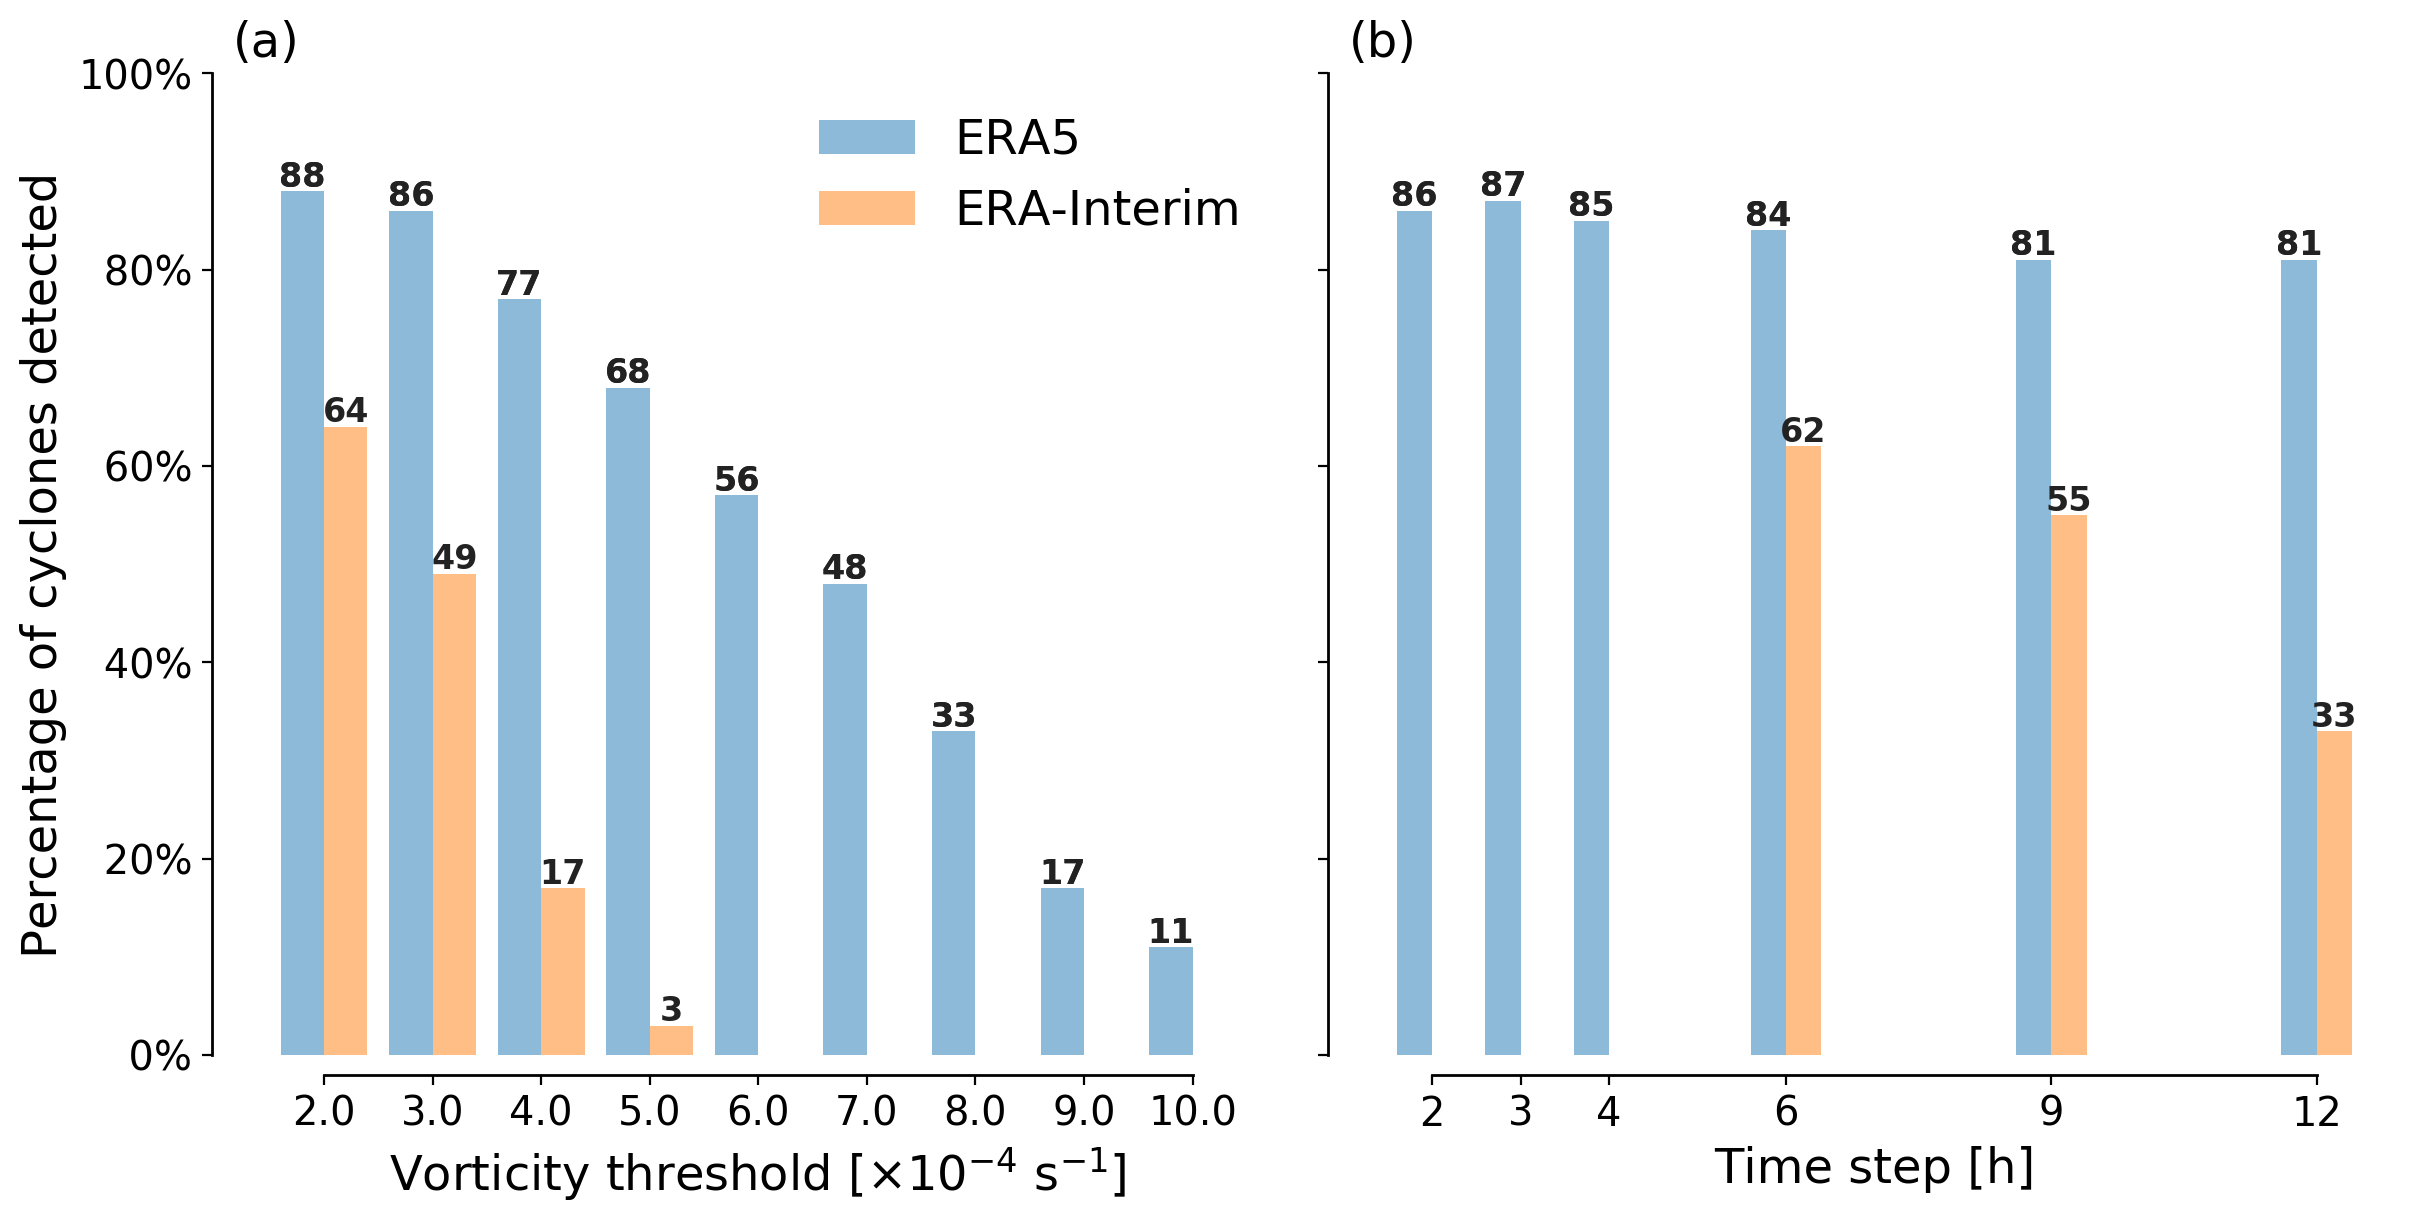

In [11]:
ncol = len(run_groups)
nrow = 1

fig, axs = plt.subplots(
    ncols=ncol, nrows=nrow, figsize=(ncol * 6, nrow * 6), constrained_layout=True, sharey=True
)

for ax, (run_group, run_group_dict) in zip(axs, run_groups.items()):
    ax.set_xlabel(run_group_dict["label"], fontsize="x-large")
    for j, (dset, color) in enumerate(zip(datasets, cc)):
        runs_grid = _get_runs_grid(dset, run_group)
        indices, xvalues = np.asarray(
            [
                [i, r.get(run_group_dict["parameter"], run_group_dict["control_value"])]
                for i, r in enumerate(runs_grid)
                if run_group_dict["parameter"] in r or len(r) == 0
            ]
        ).T
        if run_group == "tfreq":
            xindices = xvalues * dset_ctrl_tstep_h[dset]
        else:
            xindices = indices

        for i, (subset) in enumerate(subsets):
            match_counts = match_results[dset][run_group][match_i, indices.astype(int)]
            ax.bar(
                xindices + j * width,
                match_counts / n_ref,
                width=width,
                **color,
                alpha=0.5 * (i + 1),
                linewidth=0.75,
                label=f"{aliases[dset]}",
            )
        if dset == 'era5':
            if run_group == 'vort_thresh':
                _add_style_and_labels(ax, n_ref, xindices, (1e4 * xvalues).round(decimals=1), width=width, add_ylabel=True)
            else:
                _add_style_and_labels(ax, n_ref, xindices, xindices, width=width, add_ylabel=False)
        else:
            _add_style_and_labels(ax, n_ref, width=width, add_ylabel=False)

axs[0].legend(loc=1, ncol=1, fontsize="x-large", frameon=False)
for ilab, ax in zip(string.ascii_lowercase, axs):
    ax.set_title(f"({ilab})", loc="left", size="x-large")

In [12]:
fig.savefig(mypaths.plotdir / f"vrf__vort_thresh__tfreq__bs2000_100")